In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd 'drive/My Drive/Colab Notebooks/small projects/mnist'

/content/drive/My Drive/Colab Notebooks/small projects/mnist


In [0]:
data_train = pd.read_csv('datasets/train.csv')
data_test = pd.read_csv('datasets/test.csv')

In [5]:
data_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [0]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [0]:
BATCH_SIZE = 64

In [0]:
X_train = data_train.drop(columns='label')
y_train = data_train['label']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_test = data_test.copy()

In [0]:
X_train_tensor = torch.from_numpy(X_train.values).view(-1, 1, 28, 28).float()
y_train_tensor = torch.from_numpy(y_train.values)

X_val_tensor = torch.from_numpy(X_val.values).view(-1, 1, 28, 28).float()
y_val_tensor = torch.from_numpy(y_val.values)

X_test_tensor = torch.from_numpy(X_test.values).view(-1, 1, 28, 28).float()

In [0]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

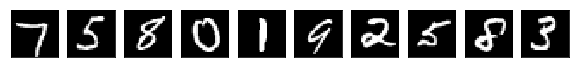

In [11]:
# visualizing some digits
plt.figure(figsize=(10, 10))
for i in range(10):
    digit = X_train.iloc[i].values.reshape(28, 28)
    plt.subplot(1, 10, i+1)
    plt.imshow(digit, cmap='gray')
    plt.xticks([])  # disable x label
    plt.yticks([])  # disable y label

In [0]:
class ConvNet(nn.Module):
    def __init__(self, channel_1, channel_2, channel_3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channel_1, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(channel_1)
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channel_2)
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channel_3)
        self.relu3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(channel_3*3*3, 10)
        
    def forward(self, x):
        out1 = self.mp1(self.relu1(self.bn1(self.conv1(x))))
        out2 = self.mp2(self.relu2(self.bn2(self.conv2(out1))))
        out3 = self.mp3(self.relu3(self.bn3(self.conv3(out2))))
        out3 = self.flatten(out3)
        scores = self.fc1(out3)
        return scores
        
    def flatten(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [0]:
def check_accuracy(loader, model, batch_size):
    num_correct = 0
    num_samples = len(loader.dataset)
    model.eval()
    with torch.no_grad():
        for t, (X_batch, y_batch) in enumerate(loader):
            X_batch = X_batch.to(device=device)
            y_batch = y_batch.to(device=device, dtype=torch.long)
            output = model(X_batch)
            y_pred = output.max(1)[1]
            num_correct += (y_pred == y_batch).sum()
        acc = float(num_correct*100) / num_samples
        print('Validation accuracy: %.2f' %acc)


def train(train_loader, val_loader, model, optimizer, criterion, epochs=1, batch_size=64, print_every=50):
    model = model.to(device=device)
    for e in range(epochs):
        correct = 0
        model.train()
        for t, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(device=device)
            y_batch = y_batch.to(device=device, dtype=torch.long)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == y_batch).sum()
            if t % print_every == 0:
                print('Epoch %d, iteration %d: loss = %.3f' %(e, t, loss.item()))
                check_accuracy(val_loader, model, batch_size)
                print()
                
def predict(X, model):
    model = model.to(device=device)
    model.eval()
    with torch.no_grad():
        X = X.to(device=device)
        output = model(X)
        y_pred = output.max(1)[1]
    return y_pred

In [0]:
model = ConvNet(16, 32, 64)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [61]:
train(train_loader, val_loader, model, optimizer, criterion, epochs=10, print_every=100)

Epoch 0, iteration 0: loss = 2.422
Validation accuracy: 12.48

Epoch 0, iteration 100: loss = 0.103
Validation accuracy: 94.12

Epoch 0, iteration 200: loss = 0.035
Validation accuracy: 95.49

Epoch 0, iteration 300: loss = 0.048
Validation accuracy: 97.10

Epoch 0, iteration 400: loss = 0.093
Validation accuracy: 97.33

Epoch 0, iteration 500: loss = 0.105
Validation accuracy: 98.00

Epoch 1, iteration 0: loss = 0.447
Validation accuracy: 97.94

Epoch 1, iteration 100: loss = 0.015
Validation accuracy: 97.96

Epoch 1, iteration 200: loss = 0.077
Validation accuracy: 97.90

Epoch 1, iteration 300: loss = 0.005
Validation accuracy: 98.33

Epoch 1, iteration 400: loss = 0.125
Validation accuracy: 98.14

Epoch 1, iteration 500: loss = 0.005
Validation accuracy: 98.40

Epoch 2, iteration 0: loss = 0.343
Validation accuracy: 98.30

Epoch 2, iteration 100: loss = 0.009
Validation accuracy: 98.39

Epoch 2, iteration 200: loss = 0.036
Validation accuracy: 98.61

Epoch 2, iteration 300: loss = 

In [0]:
y_pred = predict(X_test_tensor, model).cpu()

In [0]:
output = pd.DataFrame({'ImageId': range(1,len(y_pred)+1), 'Label': y_pred}).set_index('ImageId')

In [0]:
output.to_csv('output/output.csv')